In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

# import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
from scipy.stats import fit, gamma, norm, exponnorm, laplace, gaussian_kde

import configuration as config

from IPython.display import Image
from IPython.core.display import HTML 

/mnt/arkk/llm_detector/classifier


# Perplexity ratio score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

First, we will load up the perplexity score distributions and fit them. Then, calculate the KL divergence between the fitted distributions.

In [3]:
# Load the data
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA)

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75250 entries, 0 to 75249
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  75250 non-null  int64  
 1   Dataset                   75250 non-null  object 
 2   Source                    75250 non-null  object 
 3   String                    75250 non-null  object 
 4   Perplexity                75250 non-null  float64
 5   Cross-perplexity          75250 non-null  float64
 6   Perplexity ratio score    75250 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 4.6+ MB


In [5]:
# Extract perplexity score ratios as lists, clipping outliers higher than 1.4
scores = data_df['Perplexity ratio score'][data_df['Perplexity ratio score'] < 1.4]
human_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'human']
synthetic_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'synthetic']

# Set up bins for the combined dataset
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

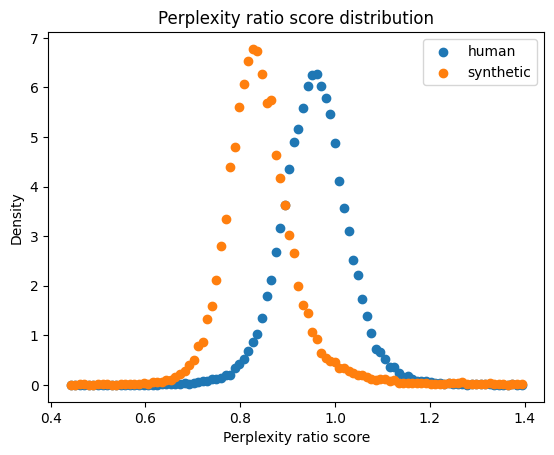

In [6]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic')

plt.title('Perplexity ratio score distribution')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

Now, try fitting a couple of different continuous distributions to see what looks good.

In [7]:
# Gaussian distribution
bounds = [[0.6,1.2],[0,10]]

human_norm = fit(norm, human_scores, bounds = bounds)
human_norm_fit = norm(human_norm.params.loc, human_norm.params.scale).pdf(bin_centers)

synthetic_norm = fit(norm, synthetic_scores, bounds = bounds)
synthetic_norm_fit = norm(synthetic_norm.params.loc, synthetic_norm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


In [8]:
# Exponential Gaussian
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


In [9]:
# Gamma distribution
bounds = [[1,100],[0,1],[0,1]]

human_gamma = fit(gamma, human_scores, bounds = bounds)
human_gamma_fit = gamma(human_gamma.params.a, human_gamma.params.loc, human_gamma.params.scale).pdf(bin_centers)

synthetic_gamma = fit(gamma, synthetic_scores, bounds = bounds)
synthetic_gamma_fit = gamma(synthetic_gamma.params.a, synthetic_gamma.params.loc, synthetic_gamma.params.scale).pdf(bin_centers)

In [10]:
# Laplace
bounds = [[0,10],[0,10]]

human_laplace = fit(laplace, human_scores, bounds = bounds)
human_laplace_fit = laplace(human_laplace.params.loc, human_laplace.params.scale).pdf(bin_centers)

synthetic_laplace = fit(laplace, synthetic_scores, bounds = bounds)
synthetic_laplace_fit = laplace(synthetic_laplace.params.loc, synthetic_laplace.params.scale).pdf(bin_centers)

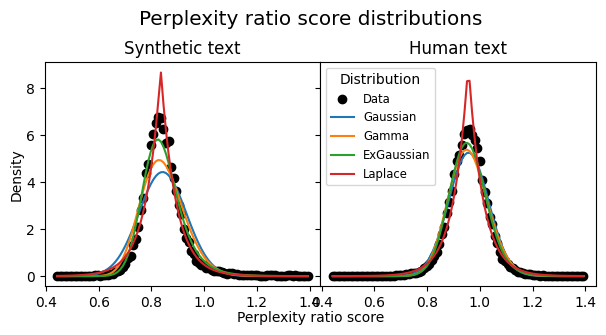

In [11]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (6, 3),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_norm_fit, label = 'Gaussian')
axs[0].plot(bin_centers, synthetic_gamma_fit, label = 'Gamma')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')
axs[0].plot(bin_centers, synthetic_laplace_fit, label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_norm_fit, label = 'Gaussian')
axs[1].plot(bin_centers, human_gamma_fit, label = 'Gamma')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')
axs[1].plot(bin_centers, human_laplace_fit, label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score distributions', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

Laplassian is too sharp, Gaussian too blunt, especialy on the synthetic text distribution, think the exponential Gaussian has it.

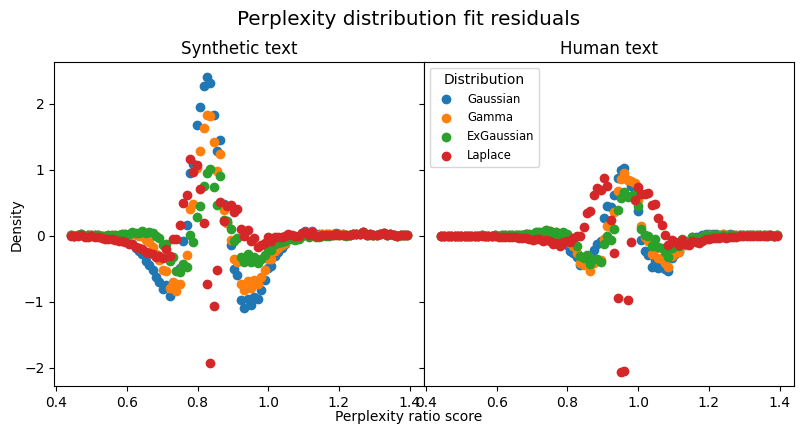

In [12]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (8, 4),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_norm_fit), label = 'Gaussian')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_gamma_fit), label = 'Gamma')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_exponnorm_fit), label = 'ExGaussian')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_laplace_fit), label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, (human_density - human_norm_fit), label = 'Gaussian')
axs[1].scatter(bin_centers, (human_density - human_gamma_fit), label = 'Gamma')
axs[1].scatter(bin_centers, (human_density - human_exponnorm_fit), label = 'ExGaussian')
axs[1].scatter(bin_centers, (human_density - human_laplace_fit), label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity distribution fit residuals', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

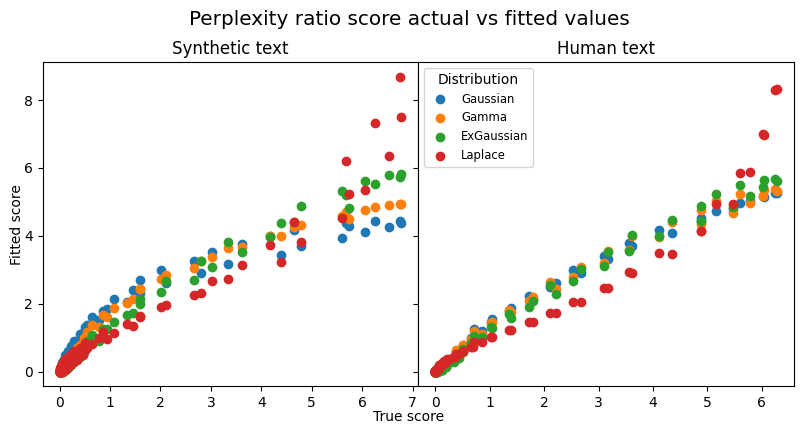

In [13]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (8, 4),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(synthetic_density, synthetic_norm_fit, label = 'Gaussian')
axs[0].scatter(synthetic_density, synthetic_gamma_fit, label = 'Gamma')
axs[0].scatter(synthetic_density, synthetic_exponnorm_fit, label = 'ExGaussian')
axs[0].scatter(synthetic_density, synthetic_laplace_fit, label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(human_density, human_norm_fit, label = 'Gaussian')
axs[1].scatter(human_density, human_gamma_fit, label = 'Gamma')
axs[1].scatter(human_density, human_exponnorm_fit, label = 'ExGaussian')
axs[1].scatter(human_density, human_laplace_fit, label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score actual vs fitted values', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'True score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Fitted score', va = 'center', ha = 'center', rotation = 90)

plt.show()

In [14]:
def kl_divergence(p, q):
    '''Takes two lists, calcualtes KD divergence'''
    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

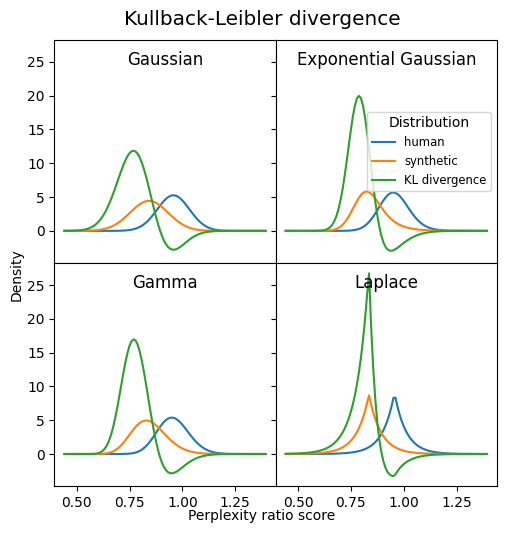

In [15]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (5, 5),
    sharex = True,
    sharey = True,
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0,0].set_title('Gaussian', y = 1.0, pad = -18)
axs[0,0].plot(bin_centers, human_norm_fit, label = 'human')
axs[0,0].plot(bin_centers, synthetic_norm_fit, label = 'synthetic')
axs[0,0].plot(bin_centers, kl_divergence(synthetic_norm_fit, human_norm_fit), label = 'KL divergence')

axs[0,1].set_title('Exponential Gaussian', y = 1.0, pad = -18)
axs[0,1].plot(bin_centers, human_exponnorm_fit, label = 'human')
axs[0,1].plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
axs[0,1].plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')

axs[1,0].set_title('Gamma', y = 1.0, pad = -18)
axs[1,0].plot(bin_centers, human_gamma_fit, label = 'human')
axs[1,0].plot(bin_centers, synthetic_gamma_fit, label = 'synthetic')
axs[1,0].plot(bin_centers, kl_divergence(synthetic_gamma_fit, human_gamma_fit), label = 'KL divergence')

axs[1,1].set_title('Laplace', y = 1.0, pad = -18)
axs[1,1].plot(bin_centers, human_laplace_fit, label = 'human')
axs[1,1].plot(bin_centers, synthetic_laplace_fit, label = 'synthetic')
axs[1,1].plot(bin_centers, kl_divergence(synthetic_laplace_fit, human_laplace_fit), label = 'KL divergence')


axs[0,1].legend(
    title = 'Distribution',
    loc = 'center right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Kullback-Leibler divergence', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

Again, the exponential gaussian looks best, I think. Proof will be in the pudding, but before we move on, I want to try this one more way. Let's see if we can use kernel density extimates of the perplexity ratio score distributions to get the KL divirgence. That way we don't even have to worry about fitting the data or justifying the choice of distribution.

In [16]:
# Get kernel density estimates for the score distributions
human_kde = gaussian_kde(human_scores)
synthetic_kde = gaussian_kde(synthetic_scores)

# Calculate the KL divergence
kl = kl_divergence(synthetic_kde.pdf(bin_centers), human_kde.pdf(bin_centers))

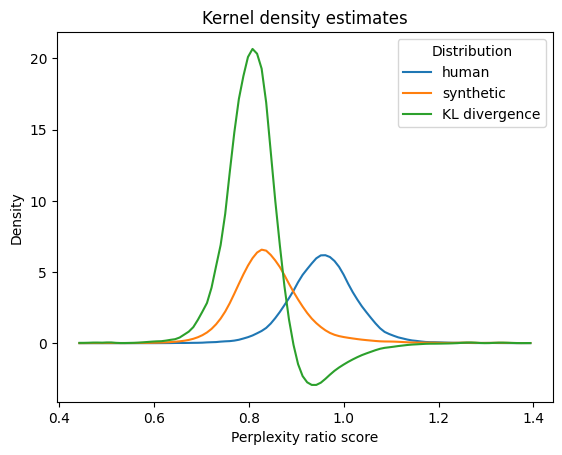

In [17]:
plt.title('Kernel density estimates')
plt.plot(bin_centers, human_kde.pdf(bin_centers), label = 'human')
plt.plot(bin_centers, synthetic_kde.pdf(bin_centers), label = 'synthetic')
plt.plot(bin_centers, kl, label = 'KL divergence')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(
    title = 'Distribution',
    loc = 'upper right'
)

plt.show()

Looks almost exactly the same as the exponential Gaussian fit - but It's nice to have a non-parametric way to do this. I think we should declare victory and move on. Next thing to work on is setting building the training data for XGBoost. We need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset.

In [18]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probibility density function to convert perpexity ratio scores
# into KL scores

# Get a list of points covering the range of score values
x = np.arange(min(scores) - 0.5, max(scores) + 0.5, 0.001).tolist()
print(f'Will calculate {len(x)} fitted vaues')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'Have {len(kl)} KL divergence values')

Will calculate 1961 fitted vaues
Have 1961 KL divergence values


Min KL count value 0
Max KL count value: 229


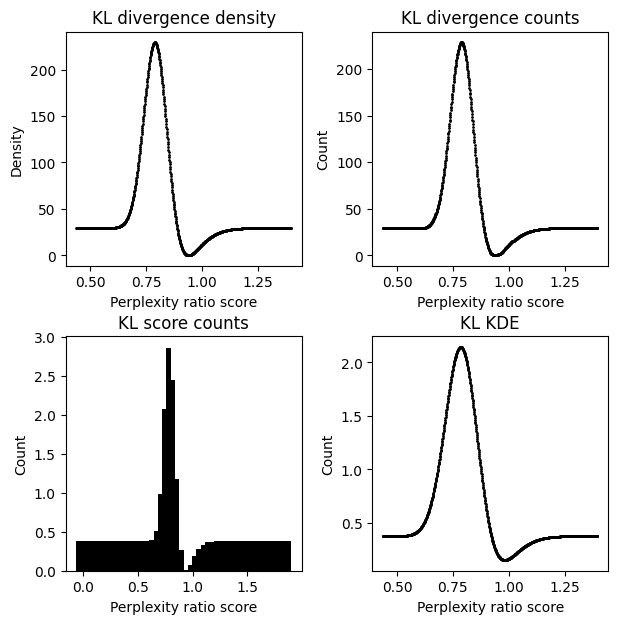

In [19]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 10
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finaly, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(scores) and j < max(scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins=50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we can run the perplexity ratio score column from the Hans text fragment data through the KL KDE's PDF and add the result to the dataframe.

In [20]:
kl_scores = kl_kde.pdf(data_df['Perplexity ratio score'])
data_df['Kullback-Leibler score'] = kl_scores

In [21]:
# Out of range data produced strange (or null) values, so clip any high outliers and replace the KL score with NAN
data_df['Kullback-Leibler score'][data_df['Perplexity ratio score'] > 1.5] = np.nan

/tmp/ipykernel_2009539/1942825392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Kullback-Leibler score'][data_df['Perplexity ratio score'] > 1.5] = np.nan


Re-plot just to be sure we got the result we expected

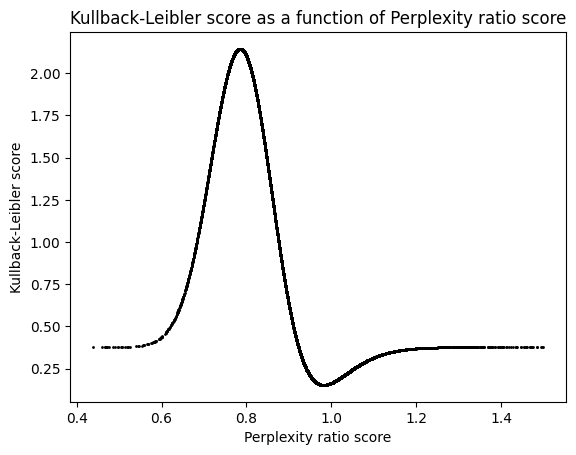

In [22]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(data_df['Perplexity ratio score'], data_df['Kullback-Leibler score'], color='black', s = 1)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [23]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA_KL

with open(output_file, 'w') as file:
    file.write(data_df.to_json())